***Содержание:***
1. Подготовка данных 
2. Анализ временного ряда
3. Обучение моделей:
 - линейная регрессия
 - случайный лес
 - CATBoost
 - LGBM
 - Промежуточные результаты
 - Prophet facebook
4. Тестирование
5. Выводы



#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import time

from matplotlib import pyplot
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
                            
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
#from sklearn.model_selection import GridSearchCV,  RandomizedSearchCV, cross_val_predict, cross_val_score
#from sklearn.model_selection import TimeSeriesSplit


!pip install catboost
import catboost as ctb
from catboost import CatBoostRegressor

!pip install lightgbm
import lightgbm as lgbm
from lightgbm import LGBMRegressor

!pip install fbprophet
from fbprophet import Prophet


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Подготовка

Загрузим представленный датасет и сразу назначим в качестве индекса поле, содержащее дату-время.

In [ ]:
try:
  # загрузка с сервера Яндекс
  df = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])#, sep='\,')
except:
  #загрузка файла с гугл диска
  from google.colab import drive
  drive.mount('/content/drive')
  df = pd.read_csv('/content/drive/MyDrive/Data_CSV/taxi.csv',index_col=[0], parse_dates=[0])#, sep='\t') 

Посмотрим, что из себя представляет исходный датасет.

In [ ]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Итак. Имеем датасет из 26 496 записей с кол-вом заказов. Пропусков нет. Шаг снятия показаний "10 мин".


Проверим границы временного ряда.

In [ ]:
#начало временного ряда
df.index.min()

Timestamp('2018-03-01 00:00:00')

In [ ]:
#окончание временного ряда
df.index.max()

Timestamp('2018-08-31 23:50:00')

Т.о. в нашем распоряжении временной ряд с 00:00 часов 1-го марта 2018 г. по 23:50 31-го августа 2018 г.

Далее проверим в хронологическом ли порядке расположены даты и время. 



In [ ]:
df.index.is_monotonic

True

ОК. Данные дата-время идут по порядку. Далее можем спокойно сделать их ресемплирование по одному часу, в соответсвии с заданием.

In [ ]:
df = df.resample('1H').sum()

Проверим что получилось после ресемплирования.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


In [ ]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


После ресемплирования имеем датасет из 4416 записей. Каждая запись содержит кол-во заказов такси в час.

## Анализ

Проведем анализ данных на предмет наличия тренда и\или сезонности, а также других закономерностей. 

Для начала просто построим график временного ряда.

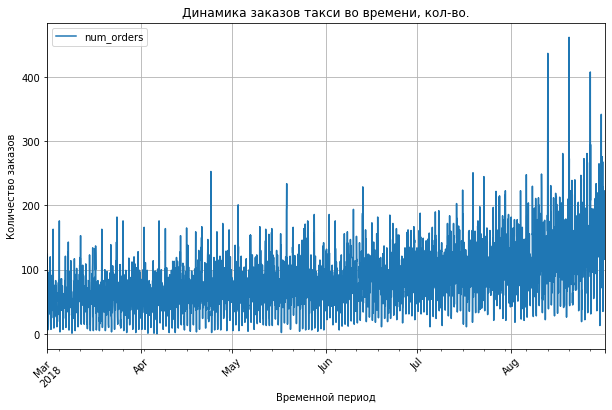

In [ ]:
df.plot(rot=45, figsize=(10,6), grid=True)
plt.title('Динамика заказов такси во времени, кол-во.')
plt.ylabel("Количество заказов")
plt.xlabel('Временной период')
plt.show()

При таком отображении трудно говорить о каких-либо закономерностях и тенденциях. 

Для большей наглядности сгруппируем кол-во заказов по дням (среднее в день).

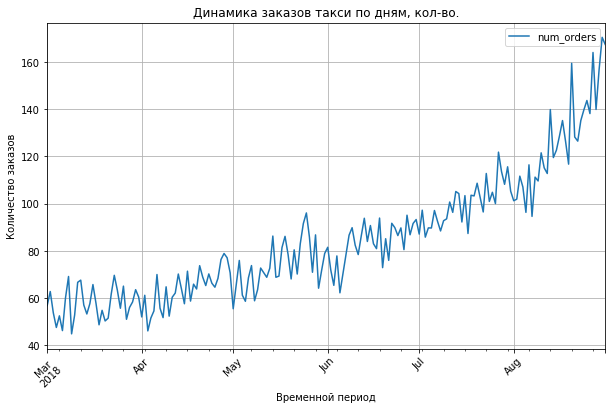

In [ ]:
df.resample('1d').mean().plot(rot=45, figsize=(10,6), grid=True)
plt.title('Динамика заказов такси по дням, кол-во.')
plt.ylabel("Количество заказов")
plt.xlabel('Временной период')
plt.show()

При такой группировке уже очевидно, что имеется тенденция к увеличению заказов такси в день.

Далее сделаем декомпозицию временного ряда на три составляющие: тренд, сезонность и остаток. 

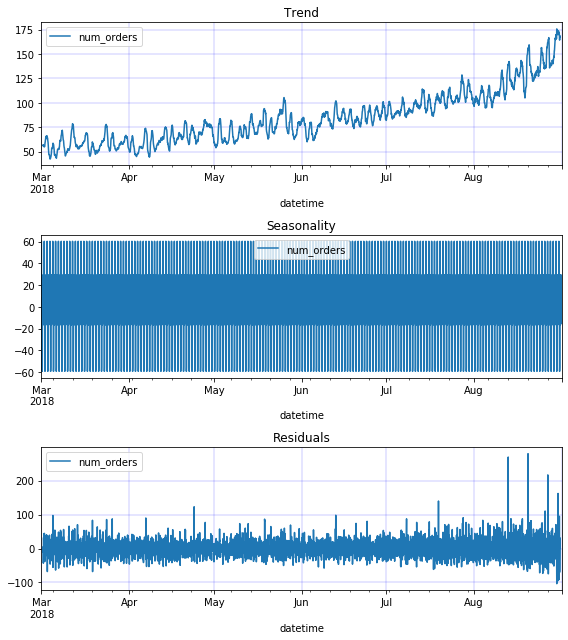

In [ ]:
# декомпозиция временного ряда
decomposed = seasonal_decompose(df)

#размеры графиков
plt.figure(figsize=(8, 9))

#график тренда
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.grid(color='b', linestyle='-', linewidth=0.2)

#график сезонности
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

#график "остатков"
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.grid(color='b', linestyle='-', linewidth=0.2)
plt.title('Residuals')

plt.tight_layout()

Наличие тренда подтвердилось. За имеющийся в нашем распоряжении временной интервал среднее кол-во заказов в день увеличилось примерно в 3 раза.

О сезонности говорить затруднительно. 
Во-первых, временной срез март-август - не полный годовой цикл.
А во-вторых, такой график сезонности ничего полезного "не сообщает". 

Остатки также нет возможности как-то целостно интерпретировать. Хотя в конце временного ряда "выбросы" стали появляться чаще и стали больше. Но есть ли в этом закономерность - не ясно.

Для большей ясности построим графики скользящего среднего и стандартного отклонения. Предположим, что есть некие "внутринедельные колебания".

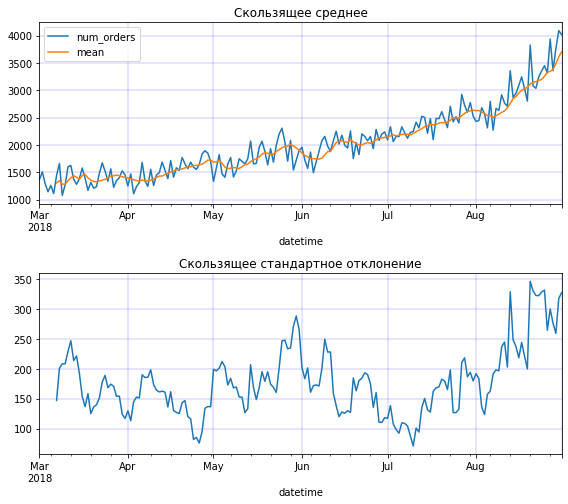

In [ ]:
# семплируем по дням, скользящее среднее 7 дней.
df1 = df.resample('1D').sum()
df1['mean'] = df1['num_orders'].rolling(7).mean()
df1['std'] = df1['num_orders'].rolling(7).std()

#df1.plot(rot=45, figsize=(10,6), grid=True) 
#plt.title('Статистические параметры временного ряда')
#plt.ylabel("Количество заказов")
#plt.xlabel('Временной период')
#plt.show()

#размеры графиков
plt.figure(figsize=(8, 10))

#график тренда
plt.subplot(311)
df1[['num_orders','mean']].plot(ax=plt.gca())
plt.title('Скользящее среднее')
plt.grid(color='b', linestyle='-', linewidth=0.2)

#график сезонности
plt.subplot(312)
df1['std'].plot(ax=plt.gca())
plt.title('Скользящее стандартное отклонение')
plt.grid(color='b', linestyle='-', linewidth=0.2)

plt.tight_layout()

Из графика очевидно, что мы имеем дело с нестационарным процессом:
- скользящее среднее растет
- скользящее стандартное отклонение меняется в диапазоне примерно от 50 до 350.

__Т.е. како-либо очевидной внутринедельной или внутримесячной закономерности выявить не удалось.__

## Обучение

В соответсвии с заданием проекта __нужно спрогнозировать количество заказов такси на следующий час.__ 
Для оценки качества модели необходимо сделать тестовую выборку размером 10% от исходных данных и достигнуть значение метрики RMSE не более 48.

Приступим.
Для начала подготовим функцию, которая формирует рабочий датасет с заданными дополнительными обучающими признаками для прогнозирования.

In [ ]:
# функция добавления дополнительных параметров исходя из заданного значения max_log и rolling_mean_size
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)

    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_new

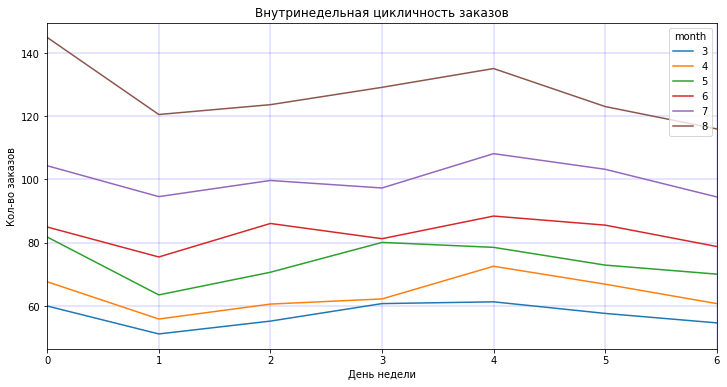

In [ ]:
#сформируем исследовательский датасет с месяцами и днями недели
data_new = df.copy()
data_new['month'] = df.index.month
data_new['dayofweek'] = df.index.dayofweek

#построим график внутринедельной цикличности
data_new.pivot_table(index =['dayofweek'], columns=['month'], values = 'num_orders', aggfunc='mean').plot(figsize=(12, 6))
plt.title("Внутринедельная цикличность заказов")
plt.ylabel("Кол-во заказов")
plt.xlabel('День недели')
plt.grid(color='b', linestyle='-', linewidth=0.2)



Т.е. опять же рост заказов от марта к августу налицо. Но еще и очевидно, что Понедельник и Пятница - максимумы. Правда, в Июне/Июле по Средам пик. Можно в этом покопаться. Может это "метро на ремонт перекрывали по средам два месяца". Тут надо разбираться, а мы ни город не знаем, ни страну.  

Можно также покопаться внутри каждого дня: утро/день/вечер или другие интервалы внутри дня поискать. Но я дико извиняюсь, если можно, то уже не в этом проекте.

Далее подготовим функцию, которая формирует обучающие наборы данных на основании заданных параметров max_lag и rolling_mean_size, которые определяют состав дополнительных обучающих признаков.

Для удобства анализа подготовим шаблон сводной таблицы результатов __results__ и функцию моделирования __modeling__(принимает модель, формирует обучающие наборы данных на основании заданных параметров max_lag и rolling_mean_size, выдаёт RMSE).

In [ ]:
# шаблон сводной таблицы результатов моделирования 
results = []
results=pd.DataFrame(columns=['REGRESSOR','RMSE-valid','RMSE-test','max_lag','rolling_mean_size'])#Fit Time, sec', 'Prediction Time, sec', 'Total time, sec.'])

In [ ]:
# обучение моделей и сохранение результато в сводной таблице result
def modeling(model, df, max_lag, rolling_mean_size):
    global results
    global features_train_columns
            
    # подготовим оубчающий и тестовый наборы
    train, test = train_test_split(df, shuffle=False, test_size=0.1, random_state=12345)
    train = train.dropna()
    
    train, valid = train_test_split(train, shuffle=False, train_size= 0.9, random_state=12345)
      
    # учебный набор для окончательного тестирования модели
    features_train = train.drop('num_orders',axis=1)
    target_train = train['num_orders']

    # валидационный набор для окончательного тестирования модели
    features_valid = valid.drop('num_orders',axis=1)
    target_valid = valid['num_orders']
    
    # тестовый набор данных для окончательного тестирования модели
    features_test = test.drop('num_orders',axis=1)
    target_test = test['num_orders']   
    
    #распечатаем размеры учебных наборов 
    print('-------------------------------------')
    print('Обучающие параметры:', features_train.shape)
    print('Обучающий целевой параметр:', target_train.shape)
    print('-------------------------------------')
    print('Валидационные параметры:', features_valid.shape)
    print('Валидационный целевой параметр:', target_valid.shape)
    print('-------------------------------------')
    print('Тестовые параметры:', features_test.shape)
    print('Тестовый целевой параметр:', target_test.shape)
    
    # учим модель для теста
    model.fit(features_train, target_train)

    #получаем предсказания для валидации
    predicted_valid = model.predict(features_valid)

    # оцениваем rmse для валидации
    rmse_valid = round((mean_squared_error(target_valid, predicted_valid)**0.5),3)
    print('-------------------------------------')
    print('RMSE для валидации:', rmse_valid)
   
    #получаем предсказания для окончательного теста
    predicted_test = model.predict(features_test)
    
    # оцениваем rmse для окончательного теста
    rmse_test = round((mean_squared_error(target_test, predicted_test)**0.5),3)
    print('-------------------------------------')
    print('RMSE для тестовой выборки:', rmse_test)
    print('-------------------------------------')
    
    # заполняем таблицу результатов
    row = [model, rmse_valid, rmse_test, max_lag, rolling_mean_size]
    results.loc[len(results)] = row 

    features_train_columns = features_train.columns

    #рисуем график качества прогноза на три дня (72 часа)
    #весь target_test длиной 442 часа
    #возьмем самый конец прогноза
    graf = pd.DataFrame({'Реальные':target_test, 'Предсказанные':predicted_test})
    graf[-72:].plot(grid=True, rot=45,figsize=(18,6))
    plt.title("Результат модели, 3 дня" )
    plt.ylabel("Кол-во заказов")
    plt.xlabel('Дата и время')
    plt.show()   

В соответсвии с заданием необходимо обучить разные модели с различными гиперпараметрами. 

Обучим и протестируем следующие модели:
- Линейную регрессию.
- Случайный лес
- CatBoostRegressor
- LGBMRegressor

Изначально все модели будут "сырые", т.е. с параметрами по умолчанию.

По результатам обучения выберем лучшую модель, которую впоследствии оптимизируем, чтобы достигнуть заданного уровня метрики RMSE.

### Линеная регрессия

-------------------------------------
Обучающие параметры: (3533, 50)
Обучающий целевой параметр: (3533,)
-------------------------------------
Валидационные параметры: (393, 50)
Валидационный целевой параметр: (393,)
-------------------------------------
Тестовые параметры: (442, 50)
Тестовый целевой параметр: (442,)
-------------------------------------
RMSE для валидации: 31.285
-------------------------------------
RMSE для тестовой выборки: 42.078
-------------------------------------


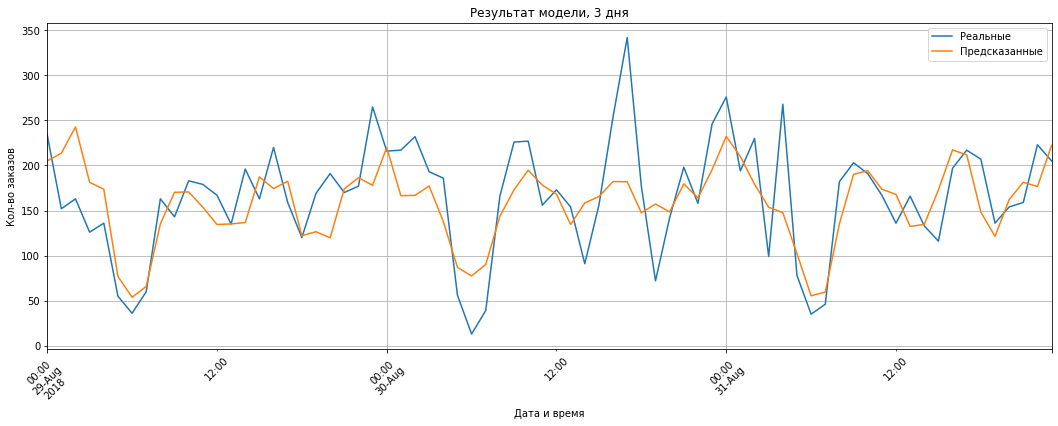

CPU times: user 659 ms, sys: 145 ms, total: 805 ms
Wall time: 930 ms


In [ ]:
%%time
lr=LinearRegression()
#print(df.head(3))
size_list = [25] # это лучший параметр rolling_mean_size
lag_list = [48] # это лучший параметр max_lag
for size in size_list:
    for lag in lag_list:
        df_work = make_features(df, lag, size)
        modeling(lr, df_work, lag, size)

__RMSE для тестовой выборки 42.08.__ Что меньше заданного проектом порога RMSE=48. 
Время работы: 205 ms.

### Случайный лес

-------------------------------------
Обучающие параметры: (3529, 54)
Обучающий целевой параметр: (3529,)
-------------------------------------
Валидационные параметры: (393, 54)
Валидационный целевой параметр: (393,)
-------------------------------------
Тестовые параметры: (442, 54)
Тестовый целевой параметр: (442,)


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



-------------------------------------
RMSE для валидации: 32.719
-------------------------------------
RMSE для тестовой выборки: 45.575
-------------------------------------


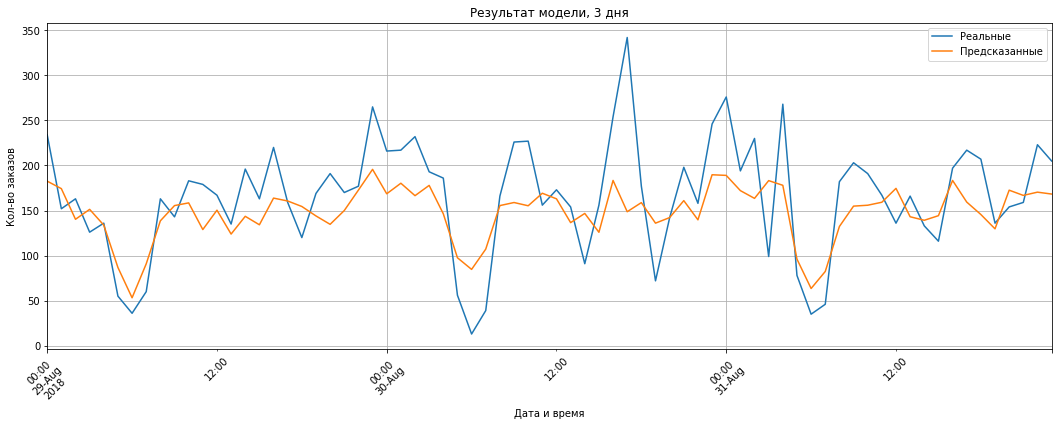

CPU times: user 1.68 s, sys: 1.16 ms, total: 1.68 s
Wall time: 1.7 s


In [ ]:
%%time
rfr = RandomForestRegressor(random_state=12345)
size_list = [16] # это лучший параметр rolling_mean_size
lag_list = [52] # это лучший параметр max_lag
#print(df.head(3))
for size in size_list:
    for lag in lag_list:
        df_work = make_features(df, lag, size)
        modeling(rfr, df_work, lag, size)

__RMSE для тестовой выборки 45.575.__ Что также меньше  заданного проектом порога RMSE=48. 
Время работы: 2.12 s.  _(странно: в Colab RMSE 44.915 выдаёт, и время меньше.  Это касается всех моделей. Устал выводы из Colab сюда переписывать)._

### CatBoostRegressor

-------------------------------------
Обучающие параметры: (3533, 26)
Обучающий целевой параметр: (3533,)
-------------------------------------
Валидационные параметры: (393, 26)
Валидационный целевой параметр: (393,)
-------------------------------------
Тестовые параметры: (442, 26)
Тестовый целевой параметр: (442,)
0:	learn: 35.7254372	total: 51.1ms	remaining: 51.1s
999:	learn: 13.6321496	total: 29.9s	remaining: 0us
-------------------------------------
RMSE для валидации: 30.684
-------------------------------------
RMSE для тестовой выборки: 45.89
-------------------------------------


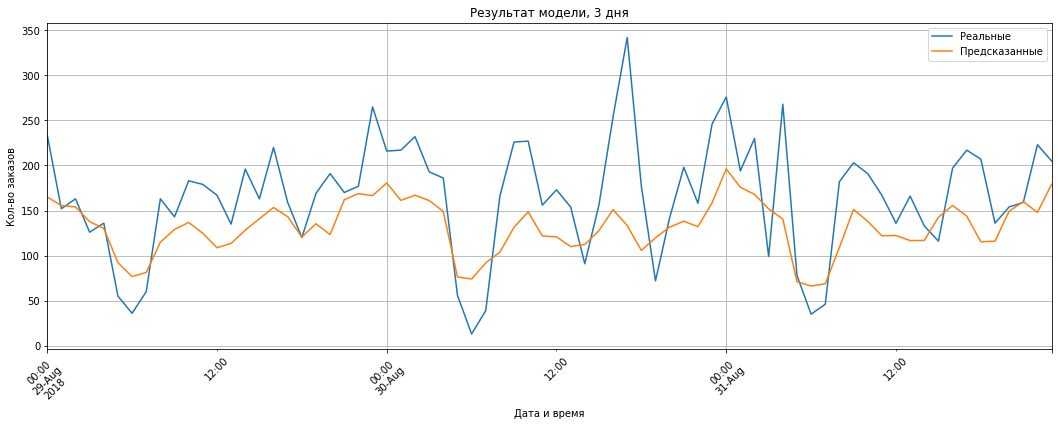

CPU times: user 27.4 s, sys: 3.52 s, total: 30.9 s
Wall time: 32.2 s


In [ ]:
%%time
cbr = CatBoostRegressor(random_state=12345, verbose=1000)
size_list = [48] # это лучший параметр rolling_mean_size
lag_list = [24] # это лучший параметр max_lag
#print(df.head(3))
for size in size_list:
    for lag in lag_list:
        df_work = make_features(df, lag, size)
        modeling(cbr, df_work, lag, size)

__RMSE для тестовой выборки 45.89.__ Что  также меньше заданного проектом порога RMSE=48. 
Время работы: 41.6 s. Долговато что-то.

Далее проверим важность обучающих параметров.

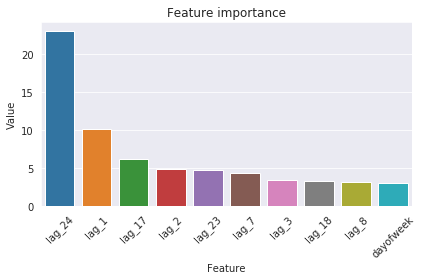

,Value,Feature
25,23.046036,lag_24
24,10.190043,lag_1
23,6.178008,lag_17
22,4.864244,lag_2
21,4.753180,lag_23
20,4.381919,lag_7
19,3.457835,lag_3
18,3.396391,lag_18
17,3.175578,lag_8
16,3.096015,dayofweek


In [ ]:
feature_importance = cbr.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(feature_importance, features_train_columns)), columns=['Value','Feature'])
sns.set_style("darkgrid")
sns.barplot(y="Value", x="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(10))
plt.title('Feature importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
feature_imp.sort_values(by='Value', ascending=False).head(10)#.sum()

Самый важный с точки зрения качества прогнозирования параметр - это 24-х часовой лаг: 21%. Далее с существенным отставанием идут часовой, 17-ти часовой и т.д. временные лаги. Диапазон скользящего среднего даже не вошел в 10-ку самых значимых обучающих признаков. Признак "день недели", на 10-м месте по важности: небольшое влияние (3.09%). Что косвенно свидетельствует о слабой внутринедельной сезонности. 

### LGBMRegressor

-------------------------------------
Обучающие параметры: (3529, 54)
Обучающий целевой параметр: (3529,)
-------------------------------------
Валидационные параметры: (393, 54)
Валидационный целевой параметр: (393,)
-------------------------------------
Тестовые параметры: (442, 54)
Тестовый целевой параметр: (442,)
-------------------------------------
RMSE для валидации: 29.916
-------------------------------------
RMSE для тестовой выборки: 43.257
-------------------------------------


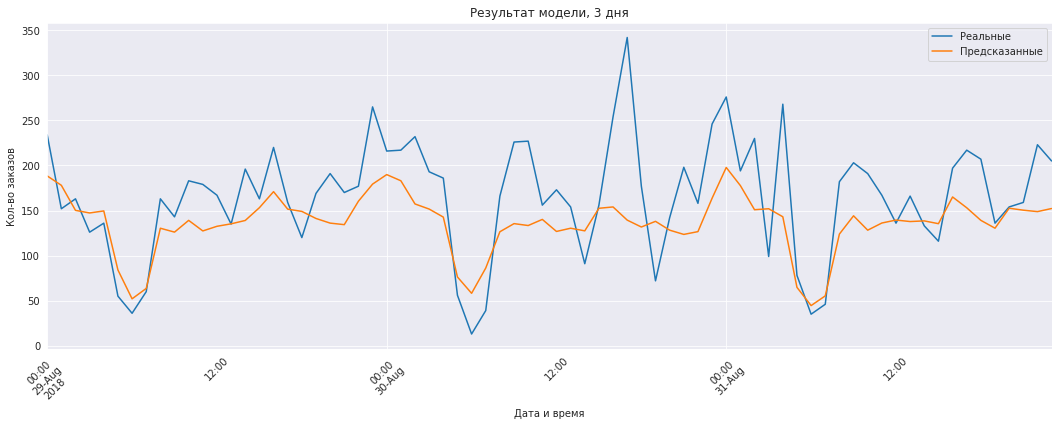

CPU times: user 3.19 s, sys: 3.71 ms, total: 3.19 s
Wall time: 3.24 s


In [ ]:
%%time
lgbm = LGBMRegressor(random_state=12345)
#features_train_columns = [] #для последующего анализа важности фичей
size_list = [24] # это лучший параметр rolling_mean_size
lag_list = [52] # это лучший параметр max_lag
#print(df.head(3))
for size in size_list:
    for lag in lag_list:
        df_work = make_features(df, lag, size)
        modeling(lgbm, df_work, lag, size)

__RMSE для тестовой выборки 43.257.__ Что также меньше заданного проектом порога RMSE=48. 
Время работы: 2.7 s. Неплохо.

Далее проверим важность обучающих параметров.

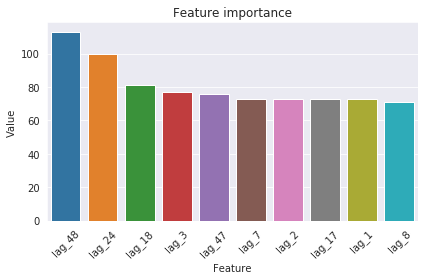

,Value,Feature
53,113,lag_48
52,100,lag_24
51,81,lag_18
50,77,lag_3
49,76,lag_47
48,73,lag_7
47,73,lag_2
46,73,lag_17
45,73,lag_1
44,71,lag_8


In [ ]:
feature_importance = lgbm.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(feature_importance, features_train_columns)), columns=['Value','Feature'])
sns.barplot(y="Value", x="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(10))
plt.title('Feature importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
feature_imp.sort_values(by='Value', ascending=False).head(10)#.sum()

Самый важный с точки зрения качества прогнозирования параметр - это 48-ми часовой лаг. Далее с несущественным отставанием идут 24-х часовой, часовой, 18-ти часовой и т.д. временные лаги. Диапазон скользящего среднего также не вошел в 10-ку самых значимых обучающих признаков. Признак "день недели" не вошел в первую десятку по важности.

### Результаты предварительного кастинга моделей

In [ ]:
#colab метод to_markdown() выполняет, а тренажер Yandex нет. поэтому такая конструкция
try:
    print(results.sort_values(by='RMSE-test', ascending=True).to_markdown())
except:
    display(results.sort_values(by='RMSE-test', ascending=True))

,REGRESSOR,RMSE-valid,RMSE-test,max_lag,rolling_mean_size
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",31.285,42.078,48,25
3,"LGBMRegressor(boosting_type='gbdt', class_weig...",29.916,43.257,52,24
1,"(DecisionTreeRegressor(criterion='mse', max_de...",32.719,45.575,52,16
2,<catboost.core.CatBoostRegressor object at 0x7...,30.684,45.890,24,48


Итак. Лучший результат показала "сырая" модель LinearRegression.  Она же и сама быстрая. Её можно было бы оптимизировать, но __целевой уровень RMSE=48 уже превзойден всеми моделями__ на стадии, так сказать, features-engineering. 

Как видно из таблицы, результаты моделей по метрике RMSE довольно близкие. 

Если судить о качестве прогнозирования по графикам (см. выше), то чисто визуально у линейной регрессии качество получше, чем у остальных.

Если бы целевой уровень RMSE был бы ниже, то очень вероятно, пришлось бы его достигать одним из бустингов, т.к. резервы оптимизации гиперпараметров у линейной регресии довольно скромные, по сравнению с бустингами.

Ну а пытаться доучивать случайный лес неразумно: он и так не самый быстрый, а при дообучении вряд ли ускорится.

Дополнительно, для сравнения, имеет смысл обучить модель из библиотеки Prophet.
Приступим.

### Prophet от FaceBook

In [ ]:
#подготовка обучающих данных
df.reset_index(level=0, inplace=True)
df.columns = ['ds','y']
predictions = int(np.ceil(df.shape[0] * 0.1))
train = df[:-predictions] 
test = df[-predictions:]

In [ ]:
#проверка горизонта прогнозирования 
predictions

In [ ]:
#обучение модели
m = Prophet()
m.fit(train)

In [ ]:
#получение прогноза
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

In [ ]:
#формирование общей таблицы для проверки результата
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(train.set_index('ds'))

In [ ]:
# расчет RMSE
predict = cmp_df[-predictions:]
predict = predict['yhat']
test = test['y']
print('RMSE для модели Prophet:', round(mean_squared_error(predict,test)**0.5,3))

Очевидно, что "сырая" модель Prophet даёт в 2.6 раза худший результат, чем самая "плохая" из ранее обученных моделей "случайный лес" (117.741 против 45.338). 

Вероятно, с Prophet можно добиться более качественного прогноза, например, добавляя "точки перелома", "праздники" и т.п. Но проделанный анализ не выявил ярких закономерностей, кроме общего тренда на рост заказов. Да и сам временной ряд у нас усеченный: март-август. 

Т.е. вариант прокачки Prophet кажется менее перспективным, чем оптимизация того же CATBoosta.


## Тестирование

Тут пусто. См. комментарии в самом верху.

## Выводы:

На основе исходного датасета был проведен анализ и обучены 4 модели регрессии.

По результатам анализа очевидно, что имеется ярко выраженный тренд на рост кол-ва заказов такси. Выявить сезонность или какие-либо другие закономерности не удалось.

Для обучения/прогнозирования были выбраны следующие модели регрессии:

- Линейнуя регрессия.
- Случайный лес
- CatBoostRegressor
- LGBMRegressor

Изначально все обученные модели "сырые", т.е. с параметрами по умолчанию.

Для каждой из "сырых" моделей итеративно был подобран собственный оптимальный набор дополнительных обучающих параметров (локальный оптимум): 
 - диапазон скользящего среднего (rolling_mean_size)
 - кол-во временных лагов (max_lag).

__Все четыре модели__ после тюнинга дополнительных обучающих параметров __показали на тестовой выборке RMSE менее 48-ми!!!__

Таким образом, __оптимизировать модели__ (подбирать гиперпараметры) __необходимости нет.__

Лучший результат показала "сырая" модель LGBMRegressor. По времени работы у неё второй результат после линейной регресси.

Дополнительно была обучена модель Prophet facebook, которая без какого-либо дополнительного тюнинга показала RMSE = 117, что, очевидно хуже всех ранее обученных моделей регрессии.

In [ ]:
print('Спасибо за внимание!')

Спасибо за внимание!
